# Stanford Dogs (Dog Breeds) — Phase 2: CNN Baseline + Experiment Scaffold

Bu notebook şunları yapar:
- Stanford Dogs datasetini **yüklü değilse indirir**, çıkarır ve `stanford_dogs_split/train` + `stanford_dogs_split/test` klasörlerini oluşturur.
- **Baseline CNN** kurar ve eğitir.
- Learning curves, **classification report** ve (ilk 20 sınıf için) **confusion matrix** üretir.

Colab için hazırlanmıştır (varsayılan yol: `/content/datasets/...`).


In [1]:
# =========================
# Imports & Environment
# =========================
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import csv
import tarfile
import urllib.request
import shutil
from scipy.io import loadmat
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


TensorFlow version: 2.19.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ==========================================
# CONFIG
# ==========================================
BASE_CONFIG = {
    "BASE_DIR": "/content/datasets/stanford_dogs",
    "SPLIT_FOLDER": "stanford_dogs_split",

    "IMG_SIZE": 128,      # 64 is faster, 128 often gives better CNN results
    "VAL_SPLIT": 0.1,
    "AUTOTUNE": tf.data.AUTOTUNE,

    "EPOCHS": 20,
    "EARLY_STOP": True,
    "EARLY_STOP_PATIENCE": 5,

    "SEED": 42,
}

CNN_CONFIG = {
    "ID": "CNN_BASE",
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-3,
    "OPTIMIZER": "adam",      # "adam" or "sgd"
    "DROPOUT": 0.3,
    "USE_BATCHNORM": True,
    "AUGMENT": True,
}

CONFIG = BASE_CONFIG.copy()
CONFIG.update(CNN_CONFIG)

os.makedirs(CONFIG["BASE_DIR"], exist_ok=True)

SEED = CONFIG["SEED"]
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Active CONFIG:")
for k in sorted(CONFIG.keys()):
    print(f"  {k}: {CONFIG[k]}")


Active CONFIG:
  AUGMENT: True
  AUTOTUNE: -1
  BASE_DIR: /content/datasets/stanford_dogs
  BATCH_SIZE: 32
  DROPOUT: 0.3
  EARLY_STOP: True
  EARLY_STOP_PATIENCE: 5
  EPOCHS: 20
  ID: CNN_BASE
  IMG_SIZE: 128
  LEARNING_RATE: 0.001
  OPTIMIZER: adam
  SEED: 42
  SPLIT_FOLDER: stanford_dogs_split
  USE_BATCHNORM: True
  VAL_SPLIT: 0.1


In [3]:
# ==========================================
# DATASET DOWNLOAD & PREPARATION (IF NEEDED)
# ==========================================
IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
LISTS_URL  = "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

def download_if_not_exists(url, dest_path):
    if os.path.exists(dest_path):
        print(f"[INFO] File already exists, skipping download: {dest_path}")
        return
    print(f"[INFO] Downloading from {url} → {dest_path}")
    urllib.request.urlretrieve(url, dest_path)
    print("[INFO] Download finished.")

def extract_if_not_exists(tar_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    print(f"[INFO] Extracting {tar_path} → {extract_to}")
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_to)
    print("[INFO] Extract finished.")

def create_train_test_split(base_dir, split_folder="stanford_dogs_split"):
    split_dir = os.path.join(base_dir, split_folder)
    if os.path.exists(split_dir):
        print(f"[INFO] Split folder already exists: {split_dir}")
        return split_dir

    images_dir = os.path.join(base_dir, "Images")
    train_mat_path = os.path.join(base_dir, "train_list.mat")
    test_mat_path  = os.path.join(base_dir, "test_list.mat")

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images folder not found at {images_dir}")
    if not (os.path.exists(train_mat_path) and os.path.exists(test_mat_path)):
        raise FileNotFoundError("train_list.mat and/or test_list.mat not found. Did lists.tar extract correctly?")

    print("[INFO] Creating train/test split folder structure...")
    os.makedirs(split_dir, exist_ok=True)
    train_root = os.path.join(split_dir, "train")
    test_root  = os.path.join(split_dir, "test")
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)

    train_mat = loadmat(train_mat_path)
    test_mat  = loadmat(test_mat_path)

    def mat_file_list_to_str_list(file_list_mat):
        paths = []
        for i in range(file_list_mat.shape[0]):
            entry = file_list_mat[i][0]
            while isinstance(entry, np.ndarray):
                entry = entry[0]
            paths.append(str(entry))
        return paths

    train_files  = mat_file_list_to_str_list(train_mat["file_list"])
    train_labels = train_mat["labels"].reshape(-1)

    test_files  = mat_file_list_to_str_list(test_mat["file_list"])
    test_labels = test_mat["labels"].reshape(-1)

    print("[INFO] Copying train images into split folder...")
    for rel_path, label in zip(train_files, train_labels):
        label_int = int(label)
        class_name = f"class_{label_int:03d}"
        src_path = os.path.join(images_dir, rel_path)
        dst_dir  = os.path.join(train_root, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(rel_path))
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

    print("[INFO] Copying test images into split folder...")
    for rel_path, label in zip(test_files, test_labels):
        label_int = int(label)
        class_name = f"class_{label_int:03d}"
        src_path = os.path.join(images_dir, rel_path)
        dst_dir  = os.path.join(test_root, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(rel_path))
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

    print(f"[INFO] Train/test split created at: {split_dir}")
    return split_dir

def prepare_stanford_dogs_dataset(base_dir, split_folder):
    os.makedirs(base_dir, exist_ok=True)

    images_tar_path = os.path.join(base_dir, "images.tar")
    lists_tar_path  = os.path.join(base_dir, "lists.tar")

    download_if_not_exists(IMAGES_URL, images_tar_path)
    download_if_not_exists(LISTS_URL,  lists_tar_path)

    if not os.path.exists(os.path.join(base_dir, "Images")):
        extract_if_not_exists(images_tar_path, base_dir)
    else:
        print("[INFO] Images folder already exists, skipping extract.")

    train_mat_path = os.path.join(base_dir, "train_list.mat")
    test_mat_path  = os.path.join(base_dir, "test_list.mat")
    if not (os.path.exists(train_mat_path) and os.path.exists(test_mat_path)):
        extract_if_not_exists(lists_tar_path, base_dir)
    else:
        print("[INFO] .mat list files already exist, skipping extract.")

    create_train_test_split(base_dir, split_folder)

# --- Run (safe to re-run) ---
prepare_stanford_dogs_dataset(CONFIG["BASE_DIR"], CONFIG["SPLIT_FOLDER"])


[INFO] Downloading from http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar → /content/datasets/stanford_dogs/images.tar
[INFO] Download finished.
[INFO] Downloading from http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar → /content/datasets/stanford_dogs/lists.tar
[INFO] Download finished.
[INFO] Extracting /content/datasets/stanford_dogs/images.tar → /content/datasets/stanford_dogs


/tmp/ipython-input-1676901771.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_to)


[INFO] Extract finished.
[INFO] Extracting /content/datasets/stanford_dogs/lists.tar → /content/datasets/stanford_dogs
[INFO] Extract finished.
[INFO] Creating train/test split folder structure...
[INFO] Copying train images into split folder...
[INFO] Copying test images into split folder...
[INFO] Train/test split created at: /content/datasets/stanford_dogs/stanford_dogs_split


In [4]:
# ==========================================
# DATASET LOADING (tf.data pipeline)
# ==========================================
BASE_DIR  = CONFIG["BASE_DIR"]
SPLIT_DIR = os.path.join(BASE_DIR, CONFIG["SPLIT_FOLDER"])

train_dir = os.path.join(SPLIT_DIR, "train")
test_dir  = os.path.join(SPLIT_DIR, "test")

IMG_SIZE   = CONFIG["IMG_SIZE"]
BATCH_SIZE = CONFIG["BATCH_SIZE"]
VAL_SPLIT  = CONFIG["VAL_SPLIT"]
SEED       = CONFIG["SEED"]

print("Train dir:", train_dir)
print("Test dir :", test_dir)

train_ds_full = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=SEED,
)

class_names = train_ds_full.class_names
num_classes = len(class_names)
print("Num classes:", num_classes)
print("Example classes:", class_names[:10])

# Split validation from training
val_batches = int(len(train_ds_full) * VAL_SPLIT)
val_ds = train_ds_full.take(val_batches)
train_ds = train_ds_full.skip(val_batches)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    batch_size=BATCH_SIZE,
)

AUTOTUNE = CONFIG["AUTOTUNE"]
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Train dir: /content/datasets/stanford_dogs/stanford_dogs_split/train
Test dir : /content/datasets/stanford_dogs/stanford_dogs_split/test
Found 12000 files belonging to 120 classes.
Num classes: 120
Example classes: ['class_001', 'class_002', 'class_003', 'class_004', 'class_005', 'class_006', 'class_007', 'class_008', 'class_009', 'class_010']
Found 8580 files belonging to 120 classes.


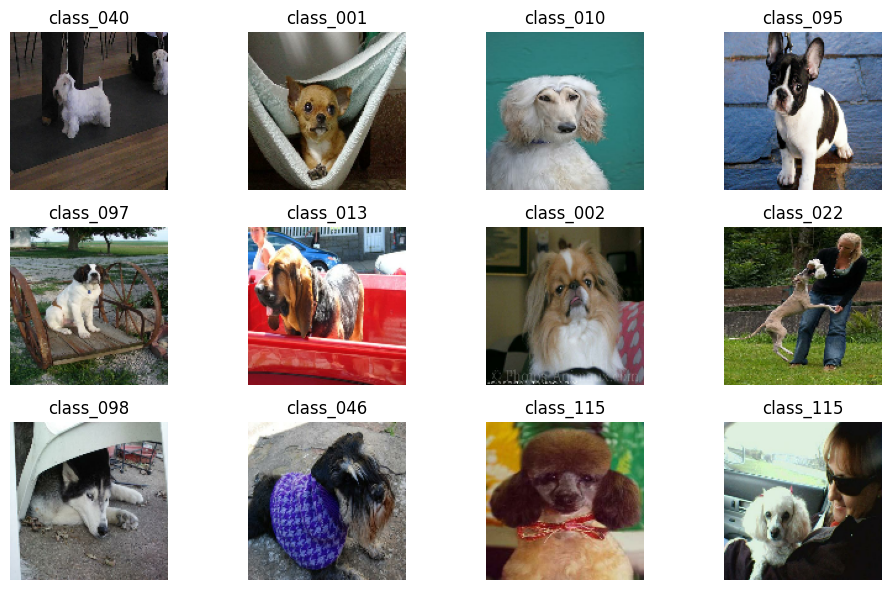

In [5]:
# ==========================================
# Quick visualization
# ==========================================
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
# ==========================================
# Baseline CNN model
# ==========================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

def build_cnn_baseline(input_shape, num_classes, cfg):
    use_bn = cfg["USE_BATCHNORM"]
    dropout = cfg["DROPOUT"]
    augment = cfg["AUGMENT"]

    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)
    if augment:
        x = data_augmentation(x)

    # Block 1
    x = layers.Conv2D(32, 3, padding="same")(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding="same")(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding="same")(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(256)(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name=cfg["ID"])

model = build_cnn_baseline((IMG_SIZE, IMG_SIZE, 3), num_classes, CONFIG)
model.summary()


Model: "CNN_BASE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 159,032 (621.22 KB)

 Trainable params: 158,072 (617.47 KB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# ==========================================
# Compile & Train
# ==========================================
lr = CONFIG["LEARNING_RATE"]
opt_name = CONFIG["OPTIMIZER"].lower()

if opt_name == "adam":
    optimizer = keras.optimizers.Adam(learning_rate=lr)
elif opt_name == "sgd":
    optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
else:
    raise ValueError("Unsupported optimizer. Use 'adam' or 'sgd'.")

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = []
if CONFIG["EARLY_STOP"]:
    callbacks.append(keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=CONFIG["EARLY_STOP_PATIENCE"],
        restore_best_weights=True
    ))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG["EPOCHS"],
    callbacks=callbacks,
)


Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 60ms/step - accuracy: 0.0120 - loss: 5.1015 - val_accuracy: 0.0127 - val_loss: 4.9759
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.0179 - loss: 4.8144 - val_accuracy: 0.0144 - val_loss: 5.2242
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.0250 - loss: 4.6967 - val_accuracy: 0.0101 - val_loss: 4.9729
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.0289 - loss: 4.6002 - val_accuracy: 0.0110 - val_loss: 4.8024
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.0354 - loss: 4.5118 - val_accuracy: 0.0177 - val_loss: 4.7522
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.0385 - loss: 4.4481 - val_accuracy: 0.0262 - val_loss: 4.6858
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.0419 - loss: 4.3940 - val_accuracy: 0.0253 - val_loss: 4.5870
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.0480 - loss: 4.3387 - 

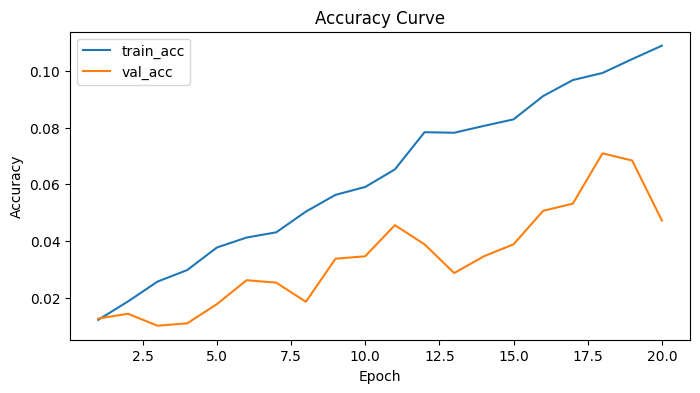

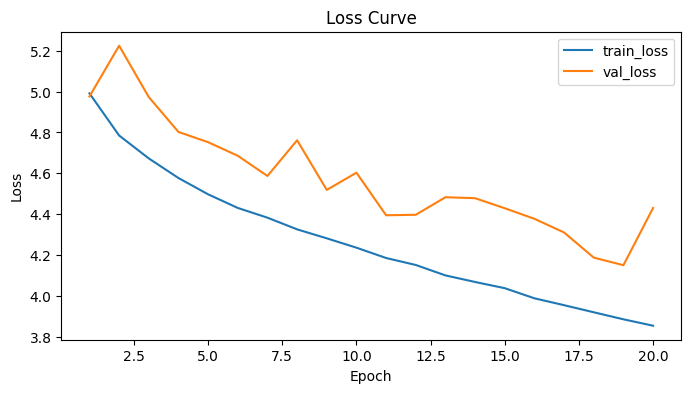

In [8]:
# ==========================================
# Learning Curves
# ==========================================
hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, hist["accuracy"], label="train_acc")
plt.plot(epochs, hist["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(epochs, hist["loss"], label="train_loss")
plt.plot(epochs, hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()


In [9]:
# ==========================================
# Evaluation (Test set)
# ==========================================
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

y_true, y_pred = [], []

for batch_images, batch_labels in test_ds:
    probs = model.predict(batch_images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(batch_labels.numpy().tolist())
    y_pred.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Test Loss: 4.1387
Test Acc : 0.0724
Classification report:
              precision    recall  f1-score   support

   class_001     0.0000    0.0000    0.0000        52
   class_002     0.1071    0.0706    0.0851        85
   class_003     0.1515    0.1974    0.1714       152
   class_004     0.0000    0.0000    0.0000        49
   class_005     0.0000    0.0000    0.0000       114
   class_006     0.2857    0.2045    0.2384        88
   class_007     0.0968    0.0312    0.0472        96
   class_008     0.0000    0.0000    0.0000        72
   class_009     0.0800    0.0278    0.0412        72
   class_010     0.0000    0.0000    0.0000       139
   class_011     0.1200    0.0800    0.0960        75
   class_012     0.0000    0.0000    0.0000        95
   class_013     0.1000    0.0115    0.0206        87
   class_014     0.0000    0.0000    0.0000        71
   class_015     0.0000    0.0000    0.0000        59
   class_016     0.1667    0.0189    0.0339        53
   class_017     0.500

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix shape: (120, 120)


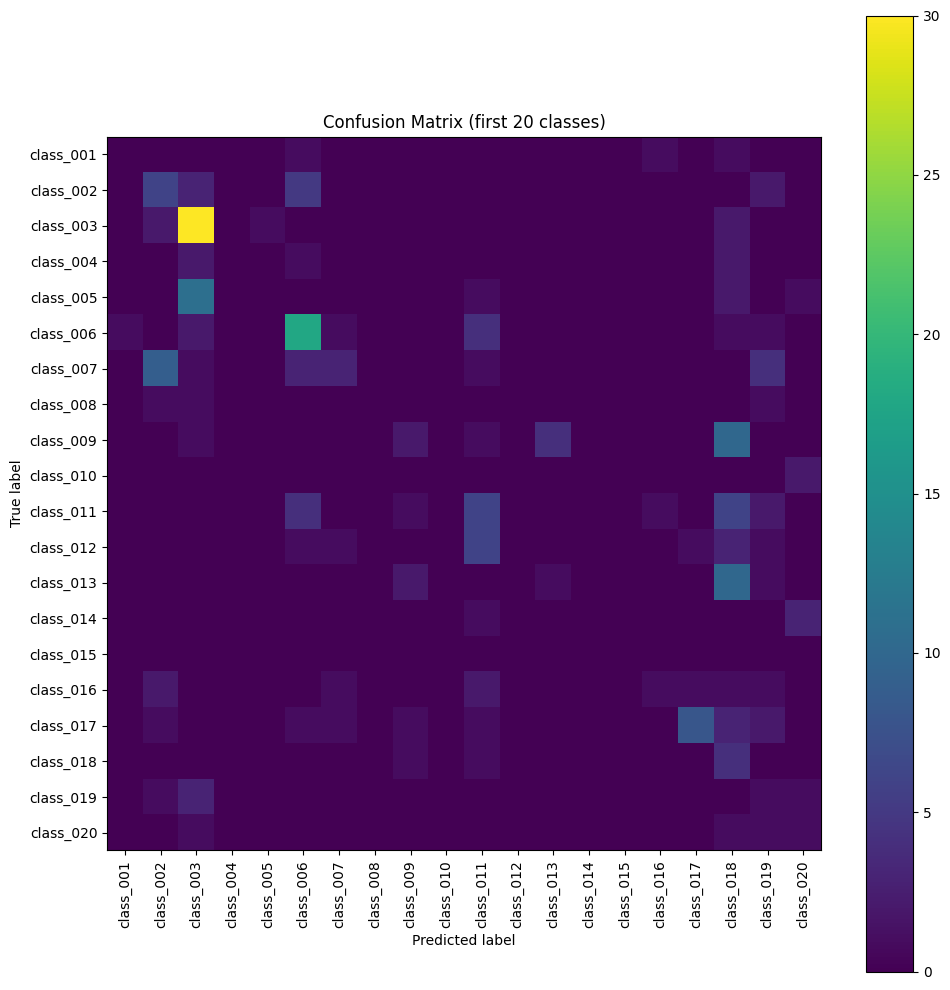

In [10]:
# ==========================================
# Confusion Matrix (120 classes -> very large)
# We plot only first N classes for readability.
# ==========================================
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

N = 20
cm_small = cm[:N, :N]

plt.figure(figsize=(10,10))
plt.imshow(cm_small, interpolation="nearest")
plt.title(f"Confusion Matrix (first {N} classes)")
plt.colorbar()
tick_marks = np.arange(N)
plt.xticks(tick_marks, class_names[:N], rotation=90)
plt.yticks(tick_marks, class_names[:N])
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


In [11]:
# ==========================================
# Save model + history
# ==========================================
os.makedirs("results", exist_ok=True)

model_path = f"results/{CONFIG['ID']}_img{IMG_SIZE}_bs{BATCH_SIZE}_lr{CONFIG['LEARNING_RATE']}.keras"
model.save(model_path)
print("Saved model to:", model_path)

hist_path = f"results/{CONFIG['ID']}_history.csv"
with open(hist_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch"] + list(history.history.keys()))
    for i in range(len(history.history["loss"])):
        writer.writerow([i+1] + [history.history[k][i] for k in history.history.keys()])
print("Saved history to:", hist_path)


Saved model to: results/CNN_BASE_img128_bs32_lr0.001.keras
Saved history to: results/CNN_BASE_history.csv


## Sonraki adım (Phase 2 için)

Bu baseline çalıştıktan sonra, Phase 2 raporu için en az 3–5 CNN varyantı dene:
- Conv blok sayısı: 2 / 3 / 4
- Filtreler: 32-64-128 vs 64-128-256
- Kernel: 3×3 vs 5×5
- Pooling: Max vs Average
- Aktivasyon: ReLU vs LeakyReLU vs ELU
- FC head: GlobalAvgPool vs Flatten + Dense

Her koşuda `CONFIG['ID']` değerini değiştirip (örn. `CNN_A1`) sonuçları `results/` altında biriktir.